In [1]:
cd /home/tvangraft/tudelft/thesis/metaengineering

/home/tvangraft/tudelft/thesis/metaengineering


In [2]:
from typing import DefaultDict, List, Hashable, Dict, Any

from src.utils.utils import get_generator, get_project_root

from src.pipeline.config import DataLoaderConfig, TaskLoaderConfig
from src.pipeline.taskloader import TaskLoader
from src.pipeline.dataloader import DataLoader

from src.orchestrator.trainer import Trainer

from src.settings.tier import Tier
from src.settings.strategy import Strategy

import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
DataLoader.DATA_FOLDER = f'{get_project_root()}/data/training/'
tier = Tier.TIER0

dl_config = DataLoaderConfig(
    additional_filters=['is_precursor'],
    additional_transforms=["log_fold_change_protein"]
)

dl = DataLoader()
dl.prepare_dataloader(dl_config)

tl = TaskLoader()
tl.prepare_taskloader(TaskLoaderConfig())

strategy = Strategy.ALL
gen = get_generator(dl, tl, strategy, tier)
tf = next(gen)

In [4]:
# PDC1, PDC2, PDC5, PDC6
pdc_enzymes = ["YLR044C", "YDR081C", "YLR134W", "YGR087C"]

for pdc_enzyme in pdc_enzymes:
    if pdc_enzyme in tf.x.columns:
        print(pdc_enzyme)

YLR044C
YGR087C


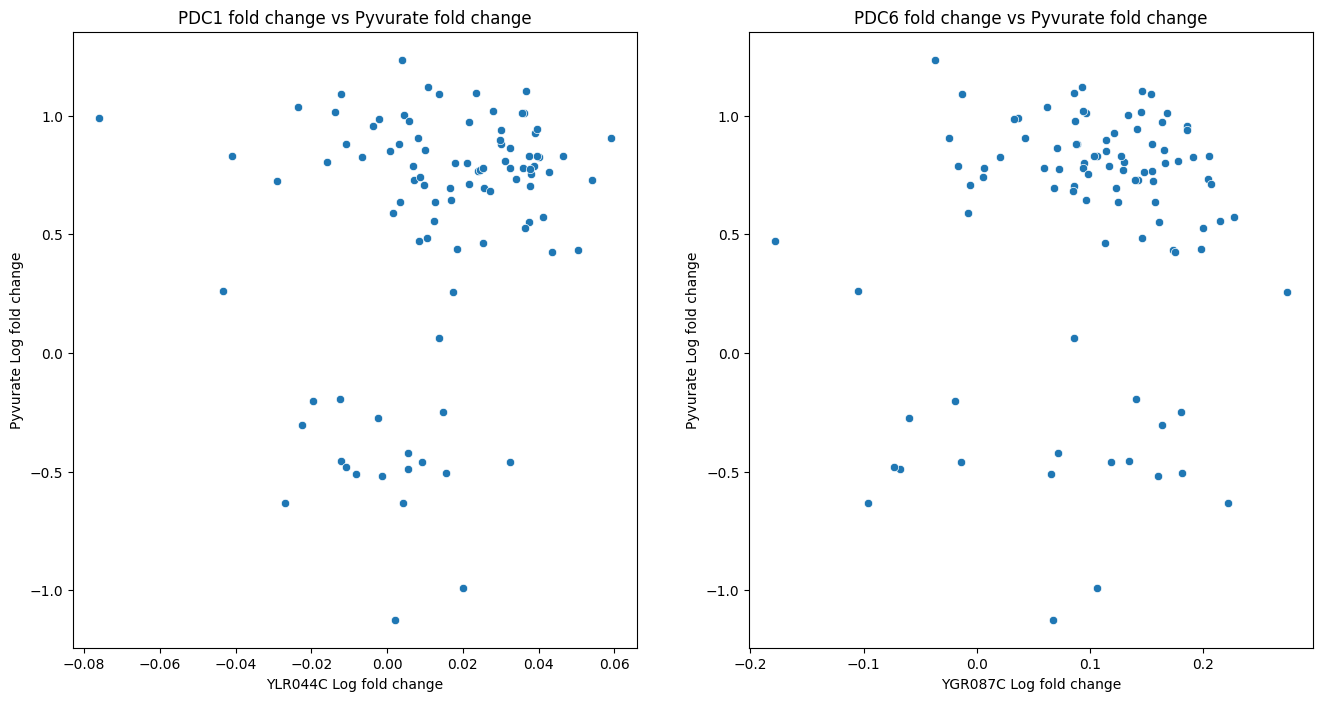

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
_df = pd.concat([
    tf.x.droplevel(1).drop_duplicates(), 
    tf.y.unstack(1)
], axis=1)

sns.scatterplot(
    data=_df,
    x="YLR044C",
    y="pyr",
    ax=ax1
).set(
    title='PDC1 fold change vs Pyvurate fold change',
    xlabel='YLR044C Log fold change',
    ylabel='Pyvurate Log fold change'
)
sns.scatterplot(
    data=_df,
    x="YGR087C",
    y="pyr",
    ax=ax2,
).set(
    title="PDC6 fold change vs Pyvurate fold change",
    xlabel='YGR087C Log fold change',
    ylabel='Pyvurate Log fold change'
)
plt.show()

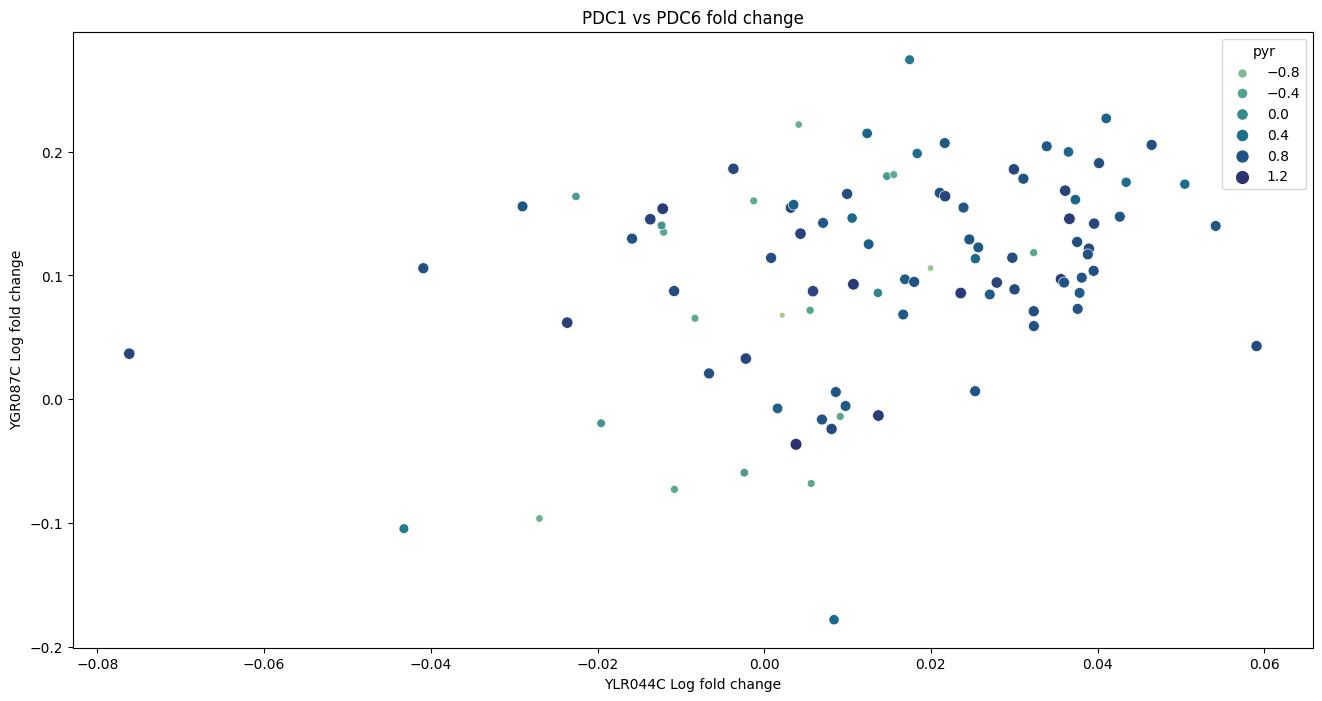

In [6]:
fig, (ax1) = plt.subplots(1, 1, figsize=(16, 8))
_df = pd.concat([
    tf.x.droplevel(1).drop_duplicates(), 
    tf.y.unstack(1)
], axis=1)

sns.scatterplot(
    data=_df,
    x="YLR044C",
    y="YGR087C",
    hue='pyr',
    size='pyr',
    palette='crest',
    ax=ax1,
).set(
    title='PDC1 vs PDC6 fold change',
    xlabel='YLR044C Log fold change',
    ylabel='YGR087C Log fold change'
)
plt.show()

# Load optimal model

In [7]:
import pickle

In [8]:
with open(f'./model/Tier.TIER0/Strategy.ALL_all.pickle', 'rb') as handle:
    model = pickle.load(handle)

with open(f'./model/Tier.TIER0/Strategy.METABOLITE_CENTRIC_pyr.pickle', 'rb') as handle:
    model_tier_0_metabolite_strategy = pickle.load(handle)

with open(f'./model/Tier.TIER0/Strategy.ONE_VS_ALL_pyr.pickle', 'rb') as handle:
    model_tier_0_one_vs_all = pickle.load(handle)

predictions = model.predict(tf.x.xs(key='pyr', axis=0, level=1))
predictions_metabolite = model_tier_0_metabolite_strategy.predict(tf.x.xs(key='pyr', axis=0, level=1))
predictions_one_vs_all = model_tier_0_one_vs_all.predict(tf.x.xs(key='pyr', axis=0, level=1))

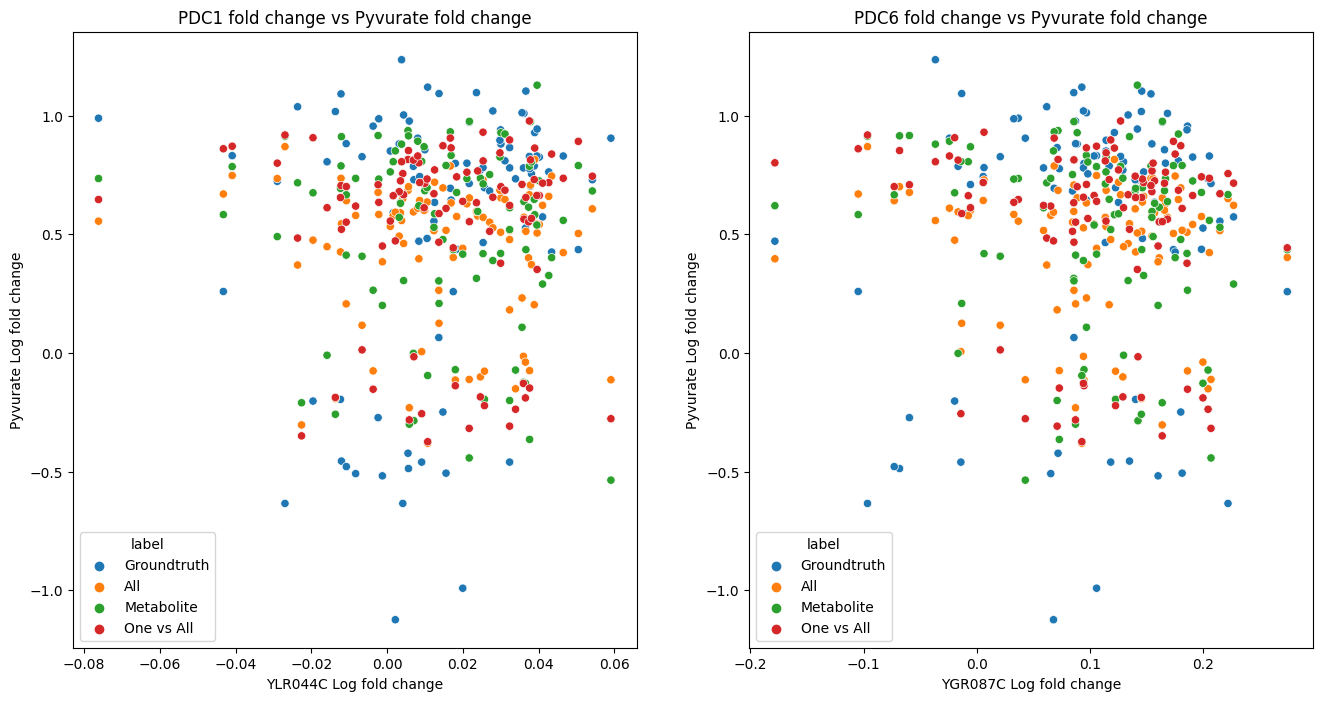

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
_df = pd.concat([
    tf.x.droplevel(1).drop_duplicates(), 
    tf.y.unstack(1)
], axis=1)

_df = _df.assign(predictions=predictions)
_df = _df.assign(predictions_metabolite=predictions_metabolite)
_df = _df.assign(predictions_one_vs_all=predictions_one_vs_all)
_df = _df[['YLR044C', 'YGR087C', 'pyr', 'predictions', 'predictions_metabolite', 'predictions_one_vs_all']].reset_index()

_df = pd.concat([
    _df[['YLR044C', 'YGR087C', 'pyr']].rename({'pyr': 'fc'}, axis=1).assign(label='Groundtruth'),
    _df[['YLR044C', 'YGR087C', 'predictions']].rename({'predictions': 'fc'}, axis=1).assign(label='All'),
    _df[['YLR044C', 'YGR087C', 'predictions_metabolite']].rename({'predictions_metabolite': 'fc'}, axis=1).assign(label='Metabolite'),
    _df[['YLR044C', 'YGR087C', 'predictions_one_vs_all']].rename({'predictions_one_vs_all': 'fc'}, axis=1).assign(label='One vs All'),
], axis=0, ignore_index=True)

sns.scatterplot(
    data=_df,
    x="YLR044C",
    y="fc",
    hue='label',
    ax=ax1
).set(
    title='PDC1 fold change vs Pyvurate fold change',
    xlabel='YLR044C Log fold change',
    ylabel='Pyvurate Log fold change'
)
sns.scatterplot(
    data=_df,
    x="YGR087C",
    y="fc",
    hue='label',
    ax=ax2,
).set(
    title="PDC6 fold change vs Pyvurate fold change",
    xlabel='YGR087C Log fold change',
    ylabel='Pyvurate Log fold change'
)
plt.show()

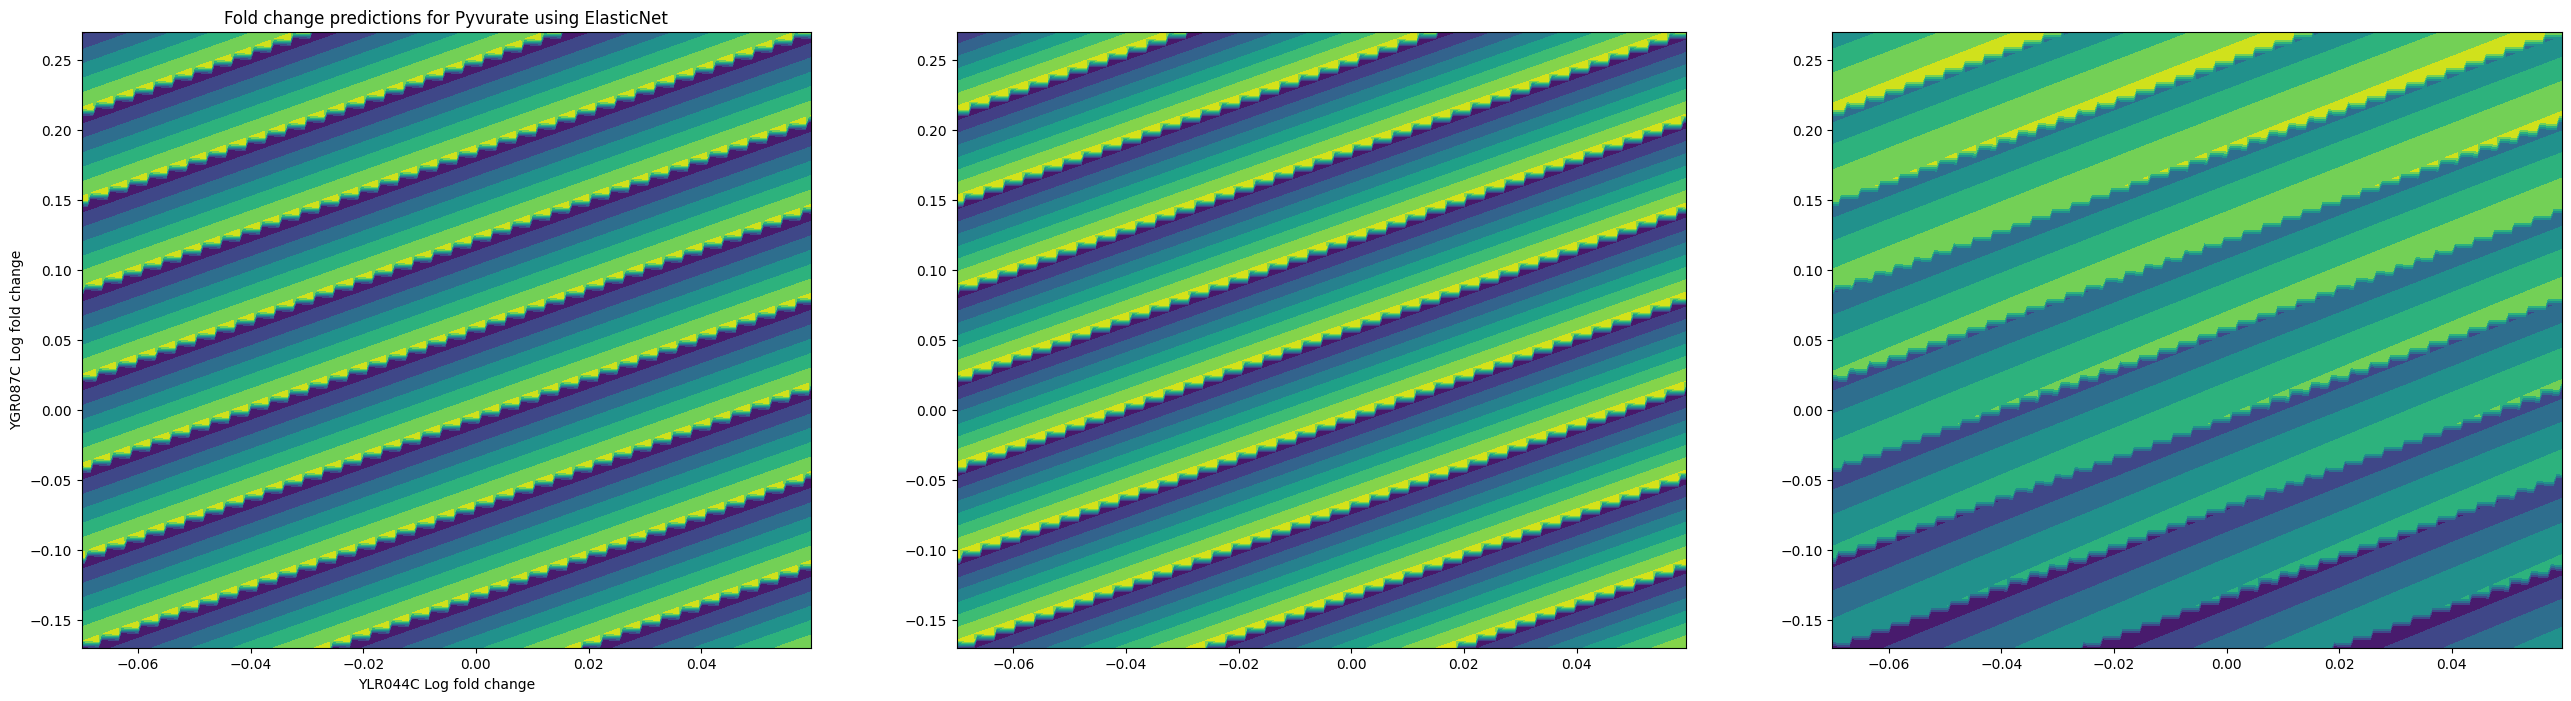

In [10]:
_df = pd.concat([
    tf.x.droplevel(1).drop_duplicates(), 
    tf.y.unstack(1)
], axis=1)

delta_x = 0.0005
delta_y = 0.005

x = np.arange(-0.07, 0.06, delta_x)
y = np.arange(-0.17, 0.27, delta_y)

X, Y = np.meshgrid(x, y)
v = np.array(np.meshgrid(x, y)).T.reshape(-1, 2)
# zero_vec = pd.DataFrame(
#     data=np.zeros(shape=(v.shape[0], tf.x.shape[1])),
#     columns=tf.x.columns,
# )
# zero_vec = tf.x.sample(v.shape[0], replace=True)

zero_vec = pd.DataFrame(
    np.repeat(_df.loc[_df['pep'].idxmax()].to_frame().T.values, v.shape[0], axis=0), 
    columns=_df.columns
)

zero_vec["YLR044C"] = v[:, 0]
zero_vec["YGR087C"] = v[:, 1]

Z_all = model.predict(zero_vec).reshape(X.shape)
Z_metabolite = model_tier_0_metabolite_strategy.predict(zero_vec).reshape(X.shape)
Z_one_vs_all = model_tier_0_one_vs_all.predict(zero_vec).reshape(X.shape)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(32, 8))

ax1.contourf(X, Y, Z_all)
ax1.set_title('Fold change predictions for Pyvurate using ElasticNet')
ax1.set_xlabel('YLR044C Log fold change')
ax1.set_ylabel('YGR087C Log fold change')

ax2.contourf(X, Y, Z_metabolite)
ax3.contourf(X, Y, Z_one_vs_all)

<AxesSubplot: >

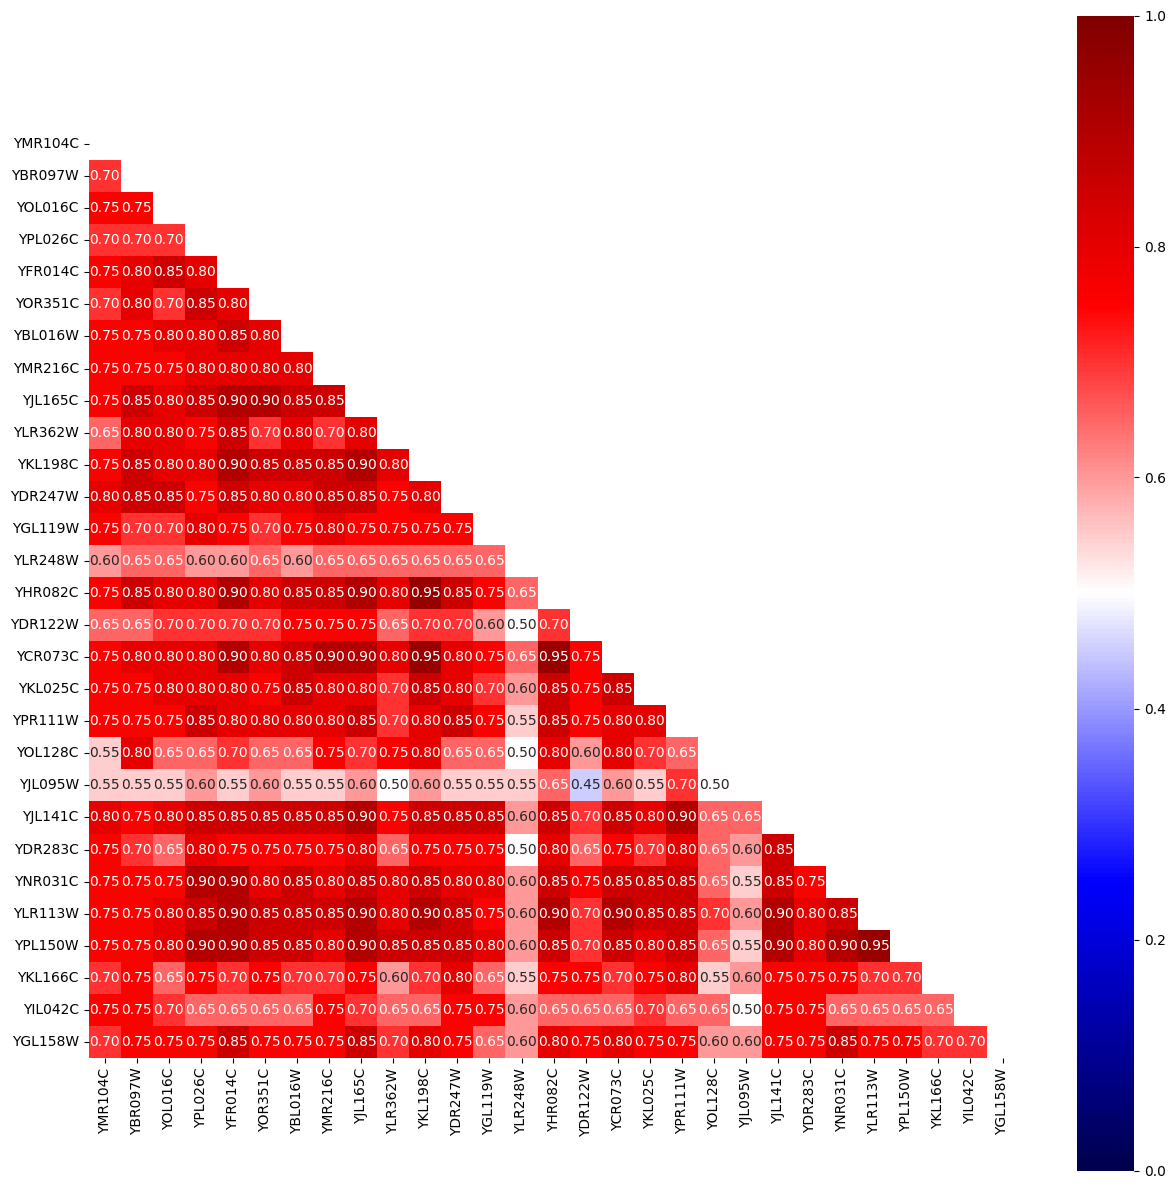

In [11]:
import glob
from typing import Callable
import itertools
import scipy

def get_lime_df(tier: Tier, strategy: Strategy):
    paths = get_explanation_paths("lime", tier, strategy)
    df = pd.concat([pd.read_json(path) for path in paths])
    return df

def get_explanation_paths(type: str, tier: Tier, strategy: Strategy):
    explanation_path = f"/home/tvangraft/tudelft/thesis/metaengineering/explanation/{tier}/{type}"
    paths = glob.glob(f"{explanation_path}/{strategy}_*")
    return paths

def count_overlap(enzymes_one: List, enzymes_two: List):
    return len(set(enzymes_one[:20]) & set(enzymes_two[:20])) / len(enzymes_one[:20])

def kendalltau(enzymes_one: List, enzymes_two: List):
    from scipy.stats import kendalltau
    return kendalltau(enzymes_one, enzymes_two)[0]

def rank_correlation_metabolite_id(df: pd.DataFrame, metabolite_id: str, agg_func):
    _df = df[df['metabolite_id'] == metabolite_id].set_index('KO_ORF')
    return rank_correlation(_df, agg_func)

def rank_correlation_knockout(df: pd.DataFrame, knockout_id: str, agg_func):
    _df = df[df['KO_ORF'] == knockout_id].set_index('metabolite_id')
    return rank_correlation(_df, agg_func)

def rank_correlation_all(df: pd.DataFrame, agg_func: Callable):
    _df = df.reset_index()
    return rank_correlation(_df, agg_func)

def rank_correlation(_df: pd.DataFrame, agg_func: Callable):
    unique_knockouts = _df.index.to_list()
    knockout_combinations = list(itertools.combinations(unique_knockouts, r=2))
    
    n = len(unique_knockouts)
    r = np.ones((n, n))
    triu = np.triu_indices(n, 1)
    tril = np.tril_indices(n, -1)
    
    key = 'exp_enzymes'
    kendalltau_correllation = [agg_func(_df.loc[left_knockout][key], _df.loc[right_knockout][key]) for (left_knockout, right_knockout) in knockout_combinations]
    
    r[triu] = kendalltau_correllation
    r[tril] = r.T[tril]
    
    return r, unique_knockouts


df = get_lime_df(tier=Tier.TIER0, strategy=Strategy.METABOLITE_CENTRIC)
df[df['metabolite_id'] == 'pyr']

correlation_matrix, knockouts = rank_correlation_metabolite_id(df, 'pyr', count_overlap)
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(
    correlation_matrix, 
    square=True, 
    annot=True,
    fmt=".2f",
    vmax=1,
    vmin=0,
    ax=ax,
    xticklabels=knockouts,
    yticklabels=knockouts,
    cmap="seismic",
    mask=np.triu(correlation_matrix),
)

In [12]:
model_tier_0_one_vs_all.regressor.named_steps

{'preprocessor': ColumnTransformer(transformers=[('num',
                                  Pipeline(steps=[('scaler', MinMaxScaler())]),
                                  ['YAL003W', 'YAL005C', 'YAL007C', 'YAL012W',
                                   'YAL035W', 'YAL038W', 'YAL042W', 'YAL044C',
                                   'YAR002C-A', 'YAR007C', 'YAR015W', 'YBL015W',
                                   'YBL024W', 'YBL026W', 'YBL030C', 'YBL039C',
                                   'YBL041W', 'YBL045C', 'YBL050W', 'YBL058W',
                                   'YBL064C', 'YBL076C', 'YBL091C', 'YBL092W',
                                   'YBL099W', 'YBR011C', 'YBR025C', 'YBR026C',
                                   'YBR031W', 'YBR035C', ...])]),
 'regressor': SVR()}

In [ ]:
model_tier_0_one_vs_all

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      ColumnTransformer(transformers=[('num',
                                                                                       Pipeline(steps=[('scaler',
                                                                                                        MinMaxScaler())]),
                                                                                       ['YAL003W',
                                                                                        'YAL005C',
                                                                                        'YAL007C',
                                                                                        'YAL012W',
                                                                                        'YAL035W',
                                                                                        'YAL038W',
                                                                                        'YAL042W',
                                                                                        'YAL044C',
                                                                                        'YAR002C-A',
                                                                                        'YAR007C',
                                                                                        'YAR015W',
                                                                                        'YBL015W',
                                                                                        'YBL024W',
                                                                                        'YBL026W',
                                                                                        'YBL030C',
                                                                                        'YBL039C',
                                                                                        'YBL041W',
                                                                                        'YBL045C',
                                                                                        'YBL050W',
                                                                                        'YBL058W',
                                                                                        'YBL064C',
                                                                                        'YBL076C',
                                                                                        'YBL091C',
                                                                                        'YBL092W',
                                                                                        'YBL099W',
                                                                                        'YBR011C',
                                                                                        'YBR025C',
                                                                                        'YBR026C',
                                                                                        'YBR031W',
                                                                                        'YBR035C', ...])])),
                                                     ('regressor', SVR())]))

In [ ]:
df = get_lime_df(tier=Tier.TIER0, strategy=Strategy.METABOLITE_CENTRIC)
df = df[(df['metabolite_id'] == 'pyr') & (df['KO_ORF'] == 'YBL016W')]

with open(f'./model/Tier.TIER0/Strategy.ALL_all.pickle', 'rb') as handle:
    model_tier_0_all = pickle.load(handle)

with open(f'./model/Tier.TIER0/Strategy.METABOLITE_CENTRIC_pyr.pickle', 'rb') as handle:
    model_tier_0_metabolite_strategy = pickle.load(handle)

with open(f'./model/Tier.TIER0/Strategy.ONE_VS_ALL_pyr.pickle', 'rb') as handle:
    model_tier_0_one_vs_all = pickle.load(handle)

print(f"{type(model_tier_0_metabolite_strategy)}")

base_frame = pd.concat([
    tf.x.droplevel(1).drop_duplicates(), 
    tf.y.unstack(1)
], axis=1)

target_enzymes = df['exp_enzymes'].values[0][:10]

def fitness(genotype):
    _df = base_frame.loc[base_frame['pep'].idxmax()].to_frame().T
    _df[target_enzymes] = genotype

    return -1 *  model_tier_0_one_vs_all.predict(_df)

bounds = np.repeat(
    [(-2, 2)], len(target_enzymes), axis=0
)

print(bounds.shape)

def print_fn(xk, convergence):
    # print(f"{xk=}")
    return

res = scipy.optimize.differential_evolution(
    func=fitness,
    bounds=bounds,
    strategy='best1bin',
    disp=True,
    seed=20,
    workers=-1,
    maxiter=100,
    popsize=1024,
    updating='deferred',
    callback=print_fn,
    init='sobol',
)

<class 'sklearn.compose._target.TransformedTargetRegressor'>
(10, 2)
differential_evolution step 1: f(x)= -0.790231
differential_evolution step 2: f(x)= -0.842855
differential_evolution step 3: f(x)= -0.842855
differential_evolution step 4: f(x)= -0.867429
differential_evolution step 5: f(x)= -0.867467
differential_evolution step 6: f(x)= -0.867467
differential_evolution step 7: f(x)= -0.867467
differential_evolution step 8: f(x)= -0.882533
differential_evolution step 9: f(x)= -0.885682
differential_evolution step 10: f(x)= -0.900527
differential_evolution step 11: f(x)= -0.900527
differential_evolution step 12: f(x)= -0.907547
differential_evolution step 13: f(x)= -0.909489
differential_evolution step 14: f(x)= -0.909489
differential_evolution step 15: f(x)= -0.925565
differential_evolution step 16: f(x)= -0.93425
differential_evolution step 17: f(x)= -0.936588
differential_evolution step 18: f(x)= -0.93973
differential_evolution step 19: f(x)= -0.943902
differential_evolution step 20

In [ ]:
fitness(res.x)

array([-5.14861901])